In [1]:
#Import Libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import linalg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def dataset_gen():
    """Generate 2 Gaussians samples with same covariance matrices"""
    # Define size and dimension. 
    n, dim = 600, 2
    # Set mean vector for class 0. 
    m_0 = np.array([0, 0]).reshape(2, 1)
    # Set mean vector for class 1.
    m_1 = np.array([1, 1]).reshape(2, 1)
    # Set covariance matrix for class 0. 
    C_0 = np.array([[1, 0],
                    [0, 1]])
    # Set covariance matrix for class 1. 
    C_1 = np.array([[1, 0],
                    [0, 1]])
    # Generate multivariate_normal for class 0.
    X_0 = np.random.multivariate_normal(mean=m_0.reshape(dim,), cov=C_0, size=n//2)
    # Generate multivariate_normal for class 1.
    X_1 = np.random.multivariate_normal(mean=m_1.reshape(dim,), cov=C_1, size=n//2)
    # Join both classes 
    X = np.concatenate((X_0, X_1), axis=0)
    # Generate appropriate class labels
    # hstack and concatenate do the same thing for this senario
    y = np.hstack((np.zeros(n//2), np.ones(n//2)))
    return X, y

In [3]:
X,y=dataset_gen()
print(X)
print(y)

[[-1.67749671 -0.49110433]
 [ 1.28904607  0.98007479]
 [-0.94120094 -0.31879857]
 ...
 [ 3.0427083   0.27847307]
 [ 0.59440083  1.55673858]
 [ 2.19776158  0.83857202]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [4]:
from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    "red_blue_classes",
    {
        "red": [(0, 1, 1), (1, 0.7, 0.7)],
        "green": [(0, 0.7, 0.7), (1, 0.7, 0.7)],
        "blue": [(0, 0.7, 0.7), (1, 1, 1)],
    },
)
plt.cm.register_cmap(cmap=cmap)

In [5]:
def plot_data(lda, X, y, y_pred, fig_index):
    splot = plt.subplot(1, 1, fig_index)
    if fig_index == 1:
        plt.title("Linear Discriminant Analysis")
        plt.ylabel("Visualization of Decision Boundaries")
    tp = y == y_pred  # True Positive
    tp0, tp1 = tp[y == 0], tp[y == 1]
    X0, X1 = X[y == 0], X[y == 1]
    X0_tp, X0_fp = X0[tp0], X0[~tp0]
    X1_tp, X1_fp = X1[tp1], X1[~tp1]

    # class 0: dots
    plt.scatter(X0_tp[:, 0], X0_tp[:, 1], marker=".", color="red")
    plt.scatter(X0_fp[:, 0], X0_fp[:, 1], marker="x", s=20, color="#990000")  # dark red

    # class 1: dots
    plt.scatter(X1_tp[:, 0], X1_tp[:, 1], marker=".", color="blue")
    plt.scatter(
        X1_fp[:, 0], X1_fp[:, 1], marker="x", s=20, color="#000099"
    )  # dark blue

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    plt.pcolormesh(
        xx, yy, Z, cmap="red_blue_classes", norm=colors.Normalize(0.0, 1.0), zorder=0
    )
    plt.contour(xx, yy, Z, [0.5], linewidths=2.0, colors="white")

    # means
    plt.plot(
        lda.means_[0][0],
        lda.means_[0][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )
    plt.plot(
        lda.means_[1][0],
        lda.means_[1][1],
        "*",
        color="yellow",
        markersize=15,
        markeredgecolor="grey",
    )

    return splot


In [6]:
def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    print('\nEigen Values',v)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        angle=180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.2)
    splot.add_artist(ell)
    splot.set_xticks(())
    splot.set_yticks(())
        
def plot_lda_cov(lda, splot):
    print("LDA\n\n Covariance Matrix\n\n",lda.covariance_,"\n\n",lda.covariance_)
    plot_ellipse(splot, lda.means_[0], lda.covariance_, "red")
    plot_ellipse(splot, lda.means_[1], lda.covariance_, "blue")
    


LDA

 Covariance Matrix

 [[0.95760349 0.06678444]
 [0.06678444 1.05059322]] 

 [[0.95760349 0.06678444]
 [0.06678444 1.05059322]]

Eigen Values [0.92272309 1.08547362]

Eigen Values [0.92272309 1.08547362]


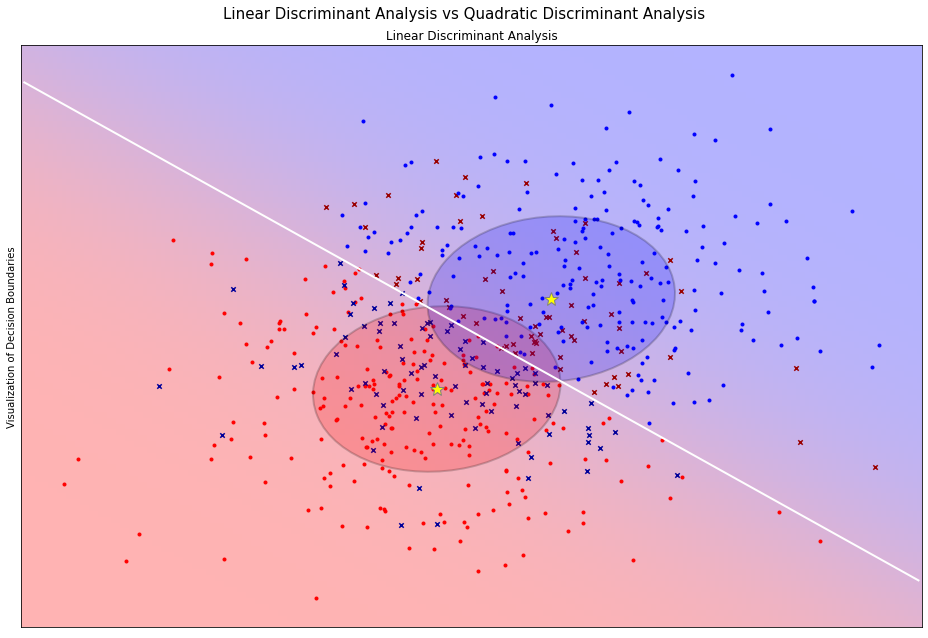

In [7]:
plt.figure(figsize=(13, 9), facecolor="white")
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)
for i, (X, y) in enumerate([dataset_gen()]): # use simulated data
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="lsqr", store_covariance=True)
    y_pred_lda = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred_lda, fig_index=1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

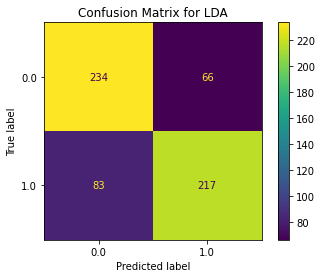

In [8]:
cm = confusion_matrix(y, y_pred_lda, labels=lda.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lda.classes_)
disp.plot()
plt.title("Confusion Matrix for LDA")
plt.show()

In [9]:
miss_class=(8+3)/600
miss_class

0.018333333333333333

# LDA on Rasin Data

In [10]:
import pandas as pd

In [11]:
df = pd.read_excel('Raisin_Dataset _SVM.xlsx')

In [12]:
df

,ar,majorAL,minorAL,ecc,conArea,extent,peri,class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,0
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,0
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,0
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,0
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,0
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,1
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,1
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,1
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,1


In [13]:
selected_features = ['ar','majorAL','class']
df2=df[selected_features]
df2

,ar,majorAL,class
0,87524,442.246011,0
1,75166,406.690687,0
2,90856,442.267048,0
3,45928,286.540559,0
4,79408,352.190770,0
...,...,...,...
895,83248,430.077308,1
896,87350,440.735698,1
897,99657,431.706981,1
898,93523,476.344094,1


In [14]:
df2[df2['class'] == 0].mean()

ar         63413.466667
majorAL      352.859249
class          0.000000
dtype: float64

In [15]:
df2[df2['class'] == 1].mean()

ar         112194.788889
majorAL       509.000652
class           1.000000
dtype: float64

In [16]:
cov_c0=df2[df2['class'] == 0].cov()
cov_c1=df2[df2['class'] == 1].cov()

In [17]:
import sympy as sp
sp.Matrix(cov_c0.iloc[:2,:2])

Matrix([
[314273786.436526, 948747.383184401],
[948747.383184401,  3553.5301639518]])

In [18]:
sp.Matrix(cov_c1.iloc[:2,:2])

Matrix([
[1538984887.08005, 3686535.70747273],
[3686535.70747273, 11187.5370004231]])

In [19]:
eigen_val, eigen_vec = np.linalg.eig(cov_c0)
print(eigen_val[:-1])

[3.14276651e+08 6.89391917e+02]


In [20]:
eigen_val, eigen_vec = np.linalg.eig(cov_c1)
print(eigen_val[:-1])

[1.53899372e+09 2.35667294e+03]


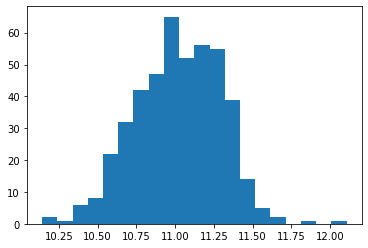

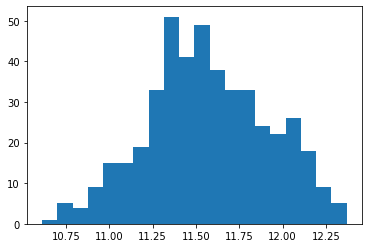

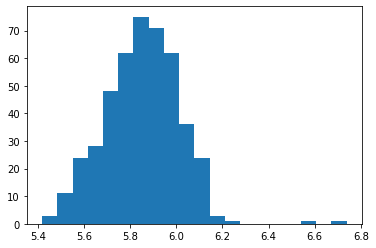

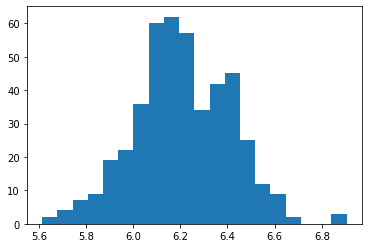

In [21]:
plt.hist(np.log(df2.loc[df2['class'] == 0,'ar']),bins=20)
plt.show()

plt.hist(np.log(df2.loc[df2['class'] == 1,'ar']),bins=20)
plt.show()

plt.hist(np.log(df2.loc[df2['class'] == 0,'majorAL']),bins=20)
plt.show()

plt.hist(np.log(df2.loc[df2['class'] == 1,'majorAL']),bins=20)
plt.show()

LDA

 Covariance Matrix

 [[9.24570160e+08 2.31249123e+06]
 [2.31249123e+06 7.35415462e+03]] 

 [[9.24570160e+08 2.31249123e+06]
 [2.31249123e+06 7.35415462e+03]]

Eigen Values [1.57025092e+03 9.24575944e+08]

Eigen Values [1.57025092e+03 9.24575944e+08]


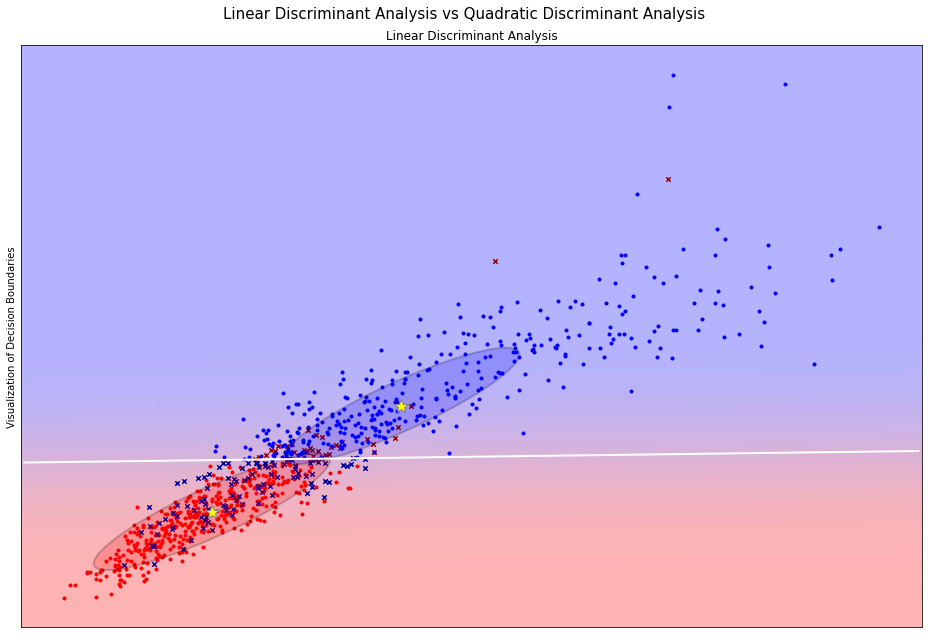

In [22]:
plt.figure(figsize=(13, 9), facecolor="white")
plt.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.98,
    fontsize=15,
)

def dataset():
    X=df2[selected_features[:-1]].to_numpy()
    y=df2['class'].to_numpy()
    return X,y


for i, (X, y) in enumerate([dataset()]): # use real data
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis(solver="lsqr", store_covariance=True)
    y_pred_lda = lda.fit(X, y).predict(X)
    splot = plot_data(lda, X, y, y_pred_lda, fig_index=1)
    plot_lda_cov(lda, splot)
    plt.axis("tight")

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

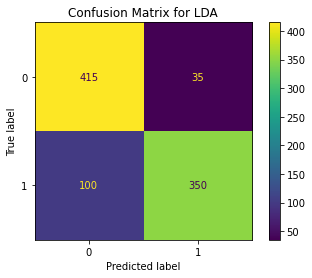

In [23]:
cm = confusion_matrix(y, y_pred_lda, labels=lda.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lda.classes_)
disp.plot()
plt.title("Confusion Matrix for LDA")
plt.show()